In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q neuralprophet pmdarima

     |████████████████████████████████| 67 kB 2.8 MB/s 
     |████████████████████████████████| 1.4 MB 13.1 MB/s 
     |████████████████████████████████| 155 kB 50.5 MB/s 
     |████████████████████████████████| 9.8 MB 21.4 MB/s 


In [ ]:
import neuralprophet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn import metrics as mt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings('ignore')

In [ ]:
np.random.seed(1)
data_root = r'/content/drive/My Drive/data/exchange/google/GOOG.csv'
TARGET_NAME = 'Close'

In [ ]:
df = pd.read_csv(data_root)

In [ ]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-06-06,724.909973,724.909973,714.609985,716.549988,716.549988,1565300
2016-06-07,719.840027,721.979980,716.549988,716.650024,716.650024,1336200
2016-06-08,723.960022,728.570007,720.580017,728.280029,728.280029,1583700
2016-06-09,722.869995,729.539978,722.335999,728.580017,728.580017,988900
2016-06-10,719.469971,725.890015,716.429993,719.409973,719.409973,1216400


In [ ]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1.258000e+03
mean,1206.878239,1218.992660,1195.830470,1207.891473,1207.891473,1.611317e+06
std,373.812704,379.030114,370.007451,374.595064,374.595064,7.029902e+05
min,671.000000,672.299988,663.283997,668.260010,668.260010,3.468000e+05
25%,955.824997,960.724976,949.627502,955.217514,955.217514,1.184300e+06
50%,1127.125000,1141.315002,1116.662537,1129.890015,1129.890015,1.424450e+06
75%,1351.767456,1364.920014,1343.679993,1352.437500,1352.437500,1.823950e+06
max,2436.939941,2452.377930,2412.514893,2433.530029,2433.530029,6.207000e+06


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1258 non-null   object 
 1   Open       1258 non-null   float64
 2   High       1258 non-null   float64
 3   Low        1258 non-null   float64
 4   Close      1258 non-null   float64
 5   Adj Close  1258 non-null   float64
 6   Volume     1258 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 68.9+ KB


In [ ]:
df.Date = pd.to_datetime(df.Date)
df.set_index('Date', drop=True, inplace=True)

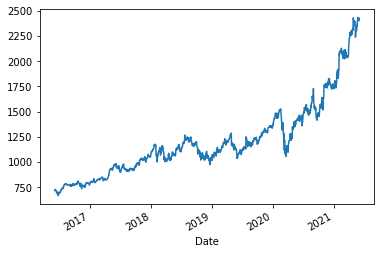

In [ ]:
df.Close.plot()
plt.show()

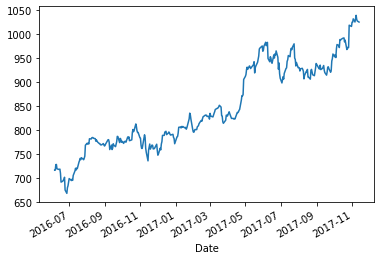

In [ ]:
df.iloc[:365, 3].plot()

In [ ]:
def aug_fuller_test(series, column_name):
    print(f'Results of Dickey-Fuller Test for column: {column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 'No Lags used', 'No of observations'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    print('Conclusion: ')
    if dftest[1] <= 0.05:
        print('Reject H0, data is Stationary')
    else:
        print('Fail to reject H0, data is non-stationary')

def ts_eval_metrics(y_true, y_pred):
    def mape(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metrics results: ')
    print(f'MSE: {mt.mean_squared_error(y_true, y_pred)}')
    print(f'MAE: {mt.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE: {np.sqrt(mt.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE: {mape(y_true, y_pred)}')
    print(f'R^2: {mt.r2_score(y_true, y_pred)}', end='\n\n')

In [ ]:
aug_fuller_test(df.Close, 'Close')

Results of Dickey-Fuller Test for coluumn: Close
Test Statistic             1.500190
p-value                    0.997525
No Lags used              22.000000
No of observations      1235.000000
Critical Value (1%)       -3.435656
Critical Value (5%)       -2.863883
Critical Value (10%)      -2.568018
dtype: float64
Conclusion: 
Fail to reject H0, data is non-stationary


In [ ]:
aug_fuller_test(df.Close.diff().dropna(), 'Close_Diff')  # d=1?

Results of Dickey-Fuller Test for column: Close_Diff
Test Statistic         -7.795101e+00
p-value                 7.755472e-12
No Lags used            2.100000e+01
No of observations      1.235000e+03
Critical Value (1%)    -3.435656e+00
Critical Value (5%)    -2.863883e+00
Critical Value (10%)   -2.568018e+00
dtype: float64
Conclusion: 
Reject H0, data is Stationary


In [ ]:
sd = seasonal_decompose(df.Close, model='add', period=365)

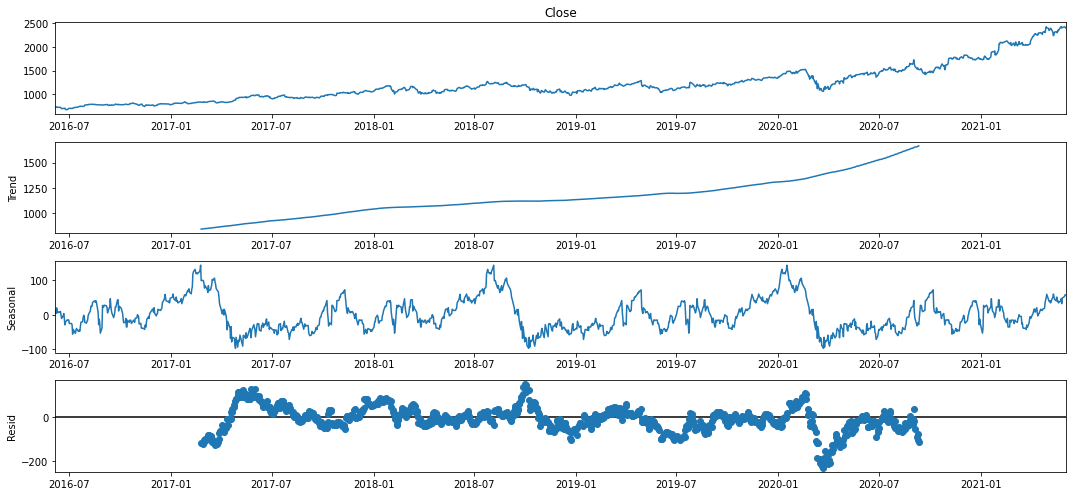

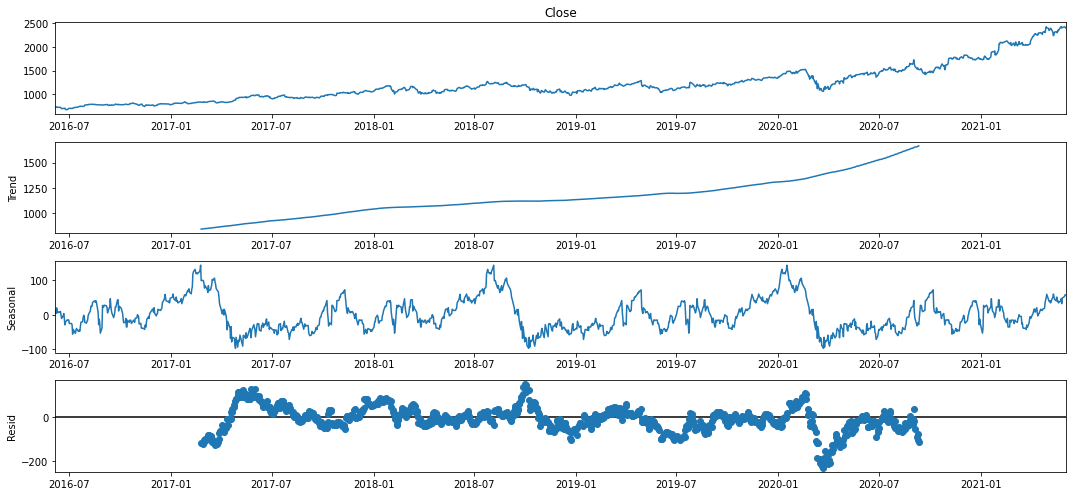

In [ ]:
sd.plot()

In [ ]:
X_train, X_test = train_test_split(df.Close, test_size=0.1, shuffle=False, random_state=1)
X_train_exog, X_test_exog = train_test_split(df.drop('Close', axis=1), test_size=0.1, shuffle=False, random_state=1)

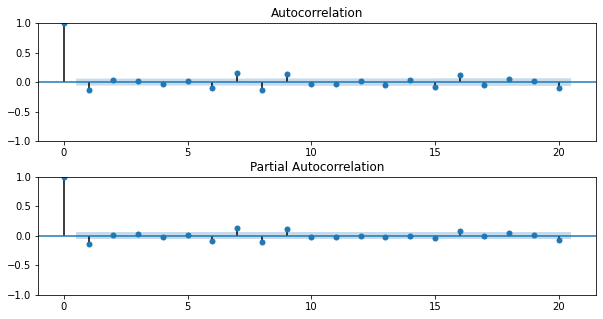

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(10, 5))
fig = plot_acf(X_train.diff().dropna(), lags=20, ax=ax[0])
fig = plot_pacf(X_train.diff().dropna(), lags=20, ax=ax[1])
plt.subplots_adjust(hspace=0.3)
plt.show() # q=0/1 p=0/1

Fitting SARIMAX for seasonal value m = 1
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-23925.719, Time=1.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-23928.410, Time=0.54 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-23927.232, Time=0.61 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-23927.776, Time=1.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-23930.410, Time=0.47 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 3.936 seconds
Model summary for m = 1
----------------------------------------------------------------------------------------------------
Evaluation metrics results: 
MSE: 3.358480482396786e-22
MAE: 1.4337173423781577e-11
RMSE: 1.83261574870369e-11
MAPE: 12.72553749514799
R^2: 1.0



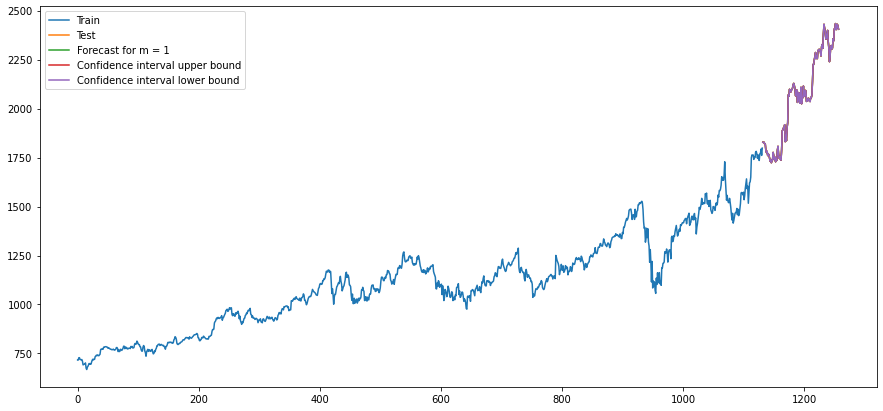

----------------------------------------------------------------------------------------------------
Diagnostic plot for Seasonal value m = 1


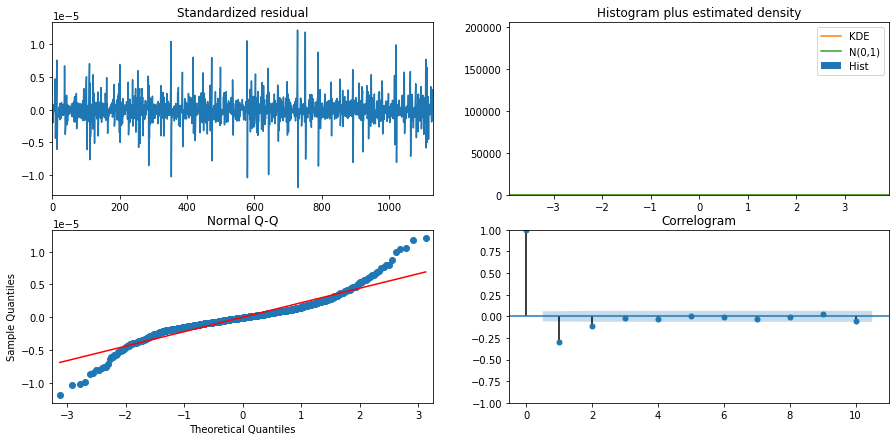

----------------------------------------------------------------------------------------------------
Fitting SARIMAX for seasonal value m = 4
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[4] intercept   : AIC=-23921.703, Time=2.01 sec
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=-23928.410, Time=0.56 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=-23925.230, Time=1.48 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=-23925.776, Time=1.63 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AIC=-23930.410, Time=0.49 sec
 ARIMA(0,1,0)(1,0,0)[4] intercept   : AIC=-23926.408, Time=1.13 sec
 ARIMA(0,1,0)(0,0,1)[4] intercept   : AIC=-23926.404, Time=1.34 sec
 ARIMA(0,1,0)(1,0,1)[4] intercept   : AIC=-23924.404, Time=1.49 sec
 ARIMA(1,1,0)(0,0,0)[4] intercept   : AIC=-23927.232, Time=0.61 sec
 ARIMA(0,1,1)(0,0,0)[4] intercept   : AIC=-23927.776, Time=1.01 sec
 ARIMA(1,1,1)(0,0,0)[4] intercept   : AIC=-23925.719, Time=1.17 sec

Best model:  ARIMA(0,1,0)(0,0,0)[4]          
Total fit time: 12.9

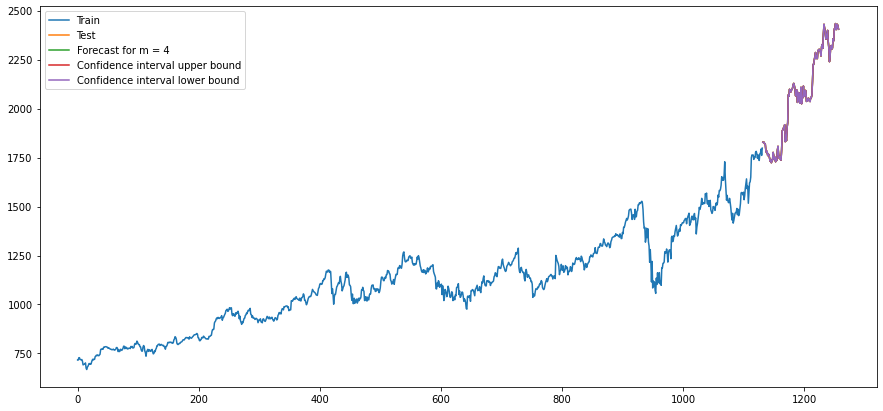

----------------------------------------------------------------------------------------------------
Diagnostic plot for Seasonal value m = 4


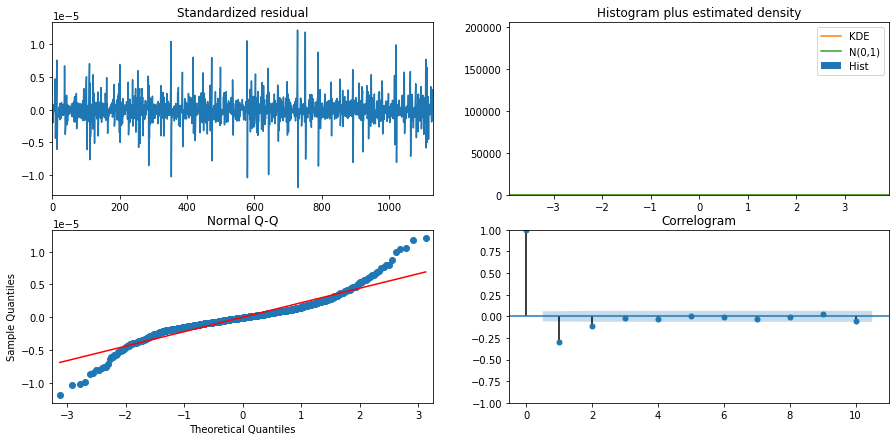

----------------------------------------------------------------------------------------------------
Fitting SARIMAX for seasonal value m = 7
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=-23921.708, Time=2.41 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=-23928.410, Time=0.56 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=-23925.227, Time=1.85 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=-23925.773, Time=1.98 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=-23930.410, Time=0.48 sec
 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=-23926.404, Time=1.43 sec
 ARIMA(0,1,0)(0,0,1)[7] intercept   : AIC=-23926.401, Time=1.68 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=-23924.401, Time=1.94 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=-23927.232, Time=0.59 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=-23927.776, Time=1.11 sec
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=-23925.719, Time=1.21 sec

Best model:  ARIMA(0,1,0)(0,0,0)[7]          
Total fit time: 15.3

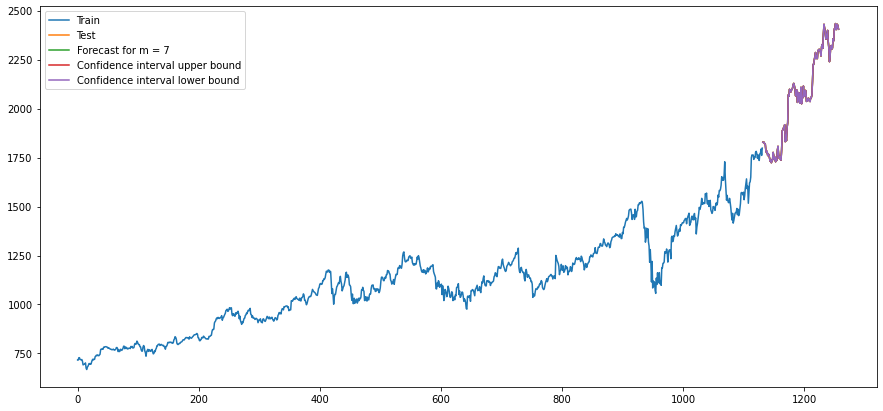

----------------------------------------------------------------------------------------------------
Diagnostic plot for Seasonal value m = 7


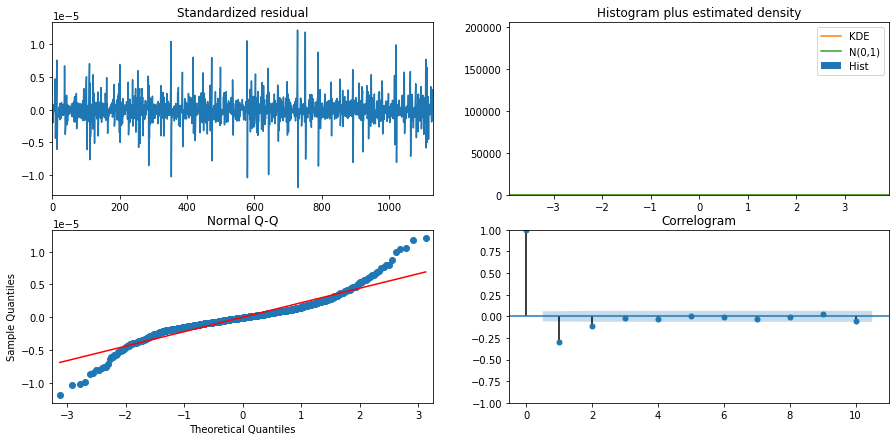

----------------------------------------------------------------------------------------------------
Fitting SARIMAX for seasonal value m = 12
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=-23921.709, Time=3.78 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-23928.410, Time=0.54 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-23925.227, Time=2.60 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-23925.766, Time=3.02 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-23930.410, Time=0.47 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-23926.404, Time=2.39 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-23926.395, Time=2.51 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=-23924.395, Time=2.80 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-23927.232, Time=0.61 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=-23927.776, Time=1.13 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=-23925.719, Time=1.23 sec

Best model:  ARIMA(0,1,0)(0,0,0)[12]          
Total f

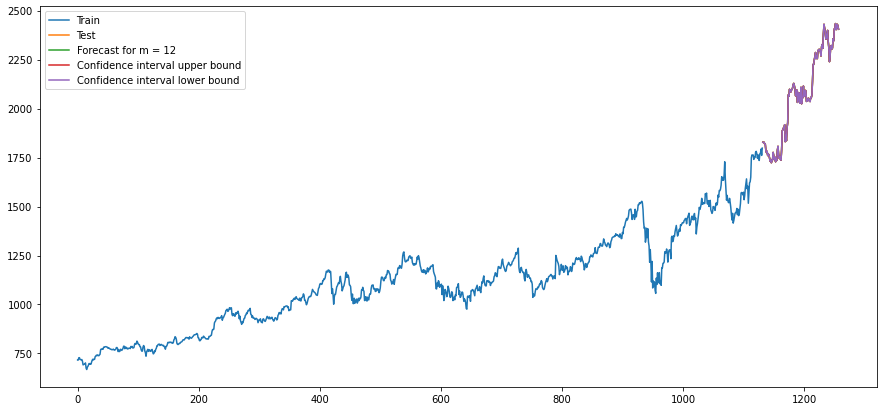

----------------------------------------------------------------------------------------------------
Diagnostic plot for Seasonal value m = 12


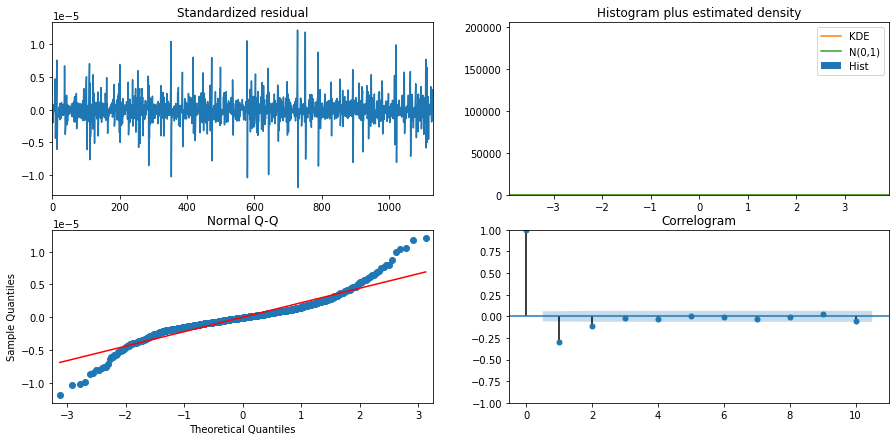

----------------------------------------------------------------------------------------------------
Fitting SARIMAX for seasonal value m = 52
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[52] intercept   : AIC=-23921.648, Time=33.54 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=-23928.410, Time=0.51 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=-23925.220, Time=28.83 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=-23925.704, Time=27.65 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=-23930.410, Time=0.44 sec
 ARIMA(0,1,0)(1,0,0)[52] intercept   : AIC=-23926.398, Time=30.89 sec
 ARIMA(0,1,0)(0,0,1)[52] intercept   : AIC=-23926.332, Time=26.93 sec
 ARIMA(0,1,0)(1,0,1)[52] intercept   : AIC=-23924.332, Time=25.35 sec
 ARIMA(1,1,0)(0,0,0)[52] intercept   : AIC=-23927.232, Time=0.58 sec
 ARIMA(0,1,1)(0,0,0)[52] intercept   : AIC=-23927.776, Time=1.03 sec
 ARIMA(1,1,1)(0,0,0)[52] intercept   : AIC=-23925.719, Time=1.13 sec

Best model:  ARIMA(0,1,0)(0,0,0)[52]          
T

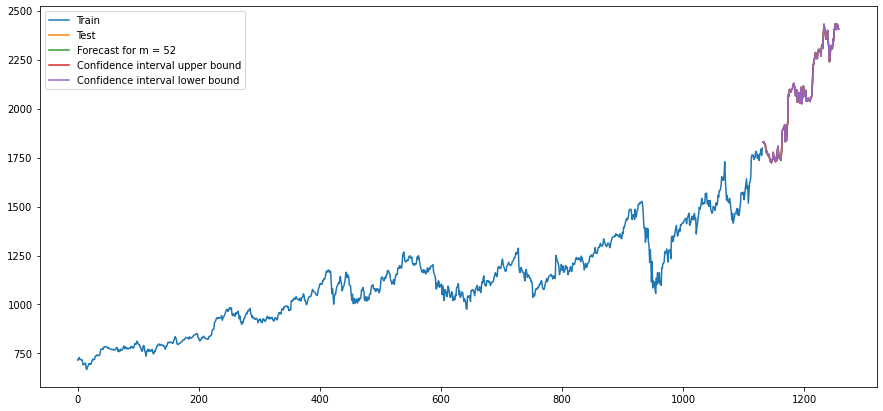

----------------------------------------------------------------------------------------------------
Diagnostic plot for Seasonal value m = 52


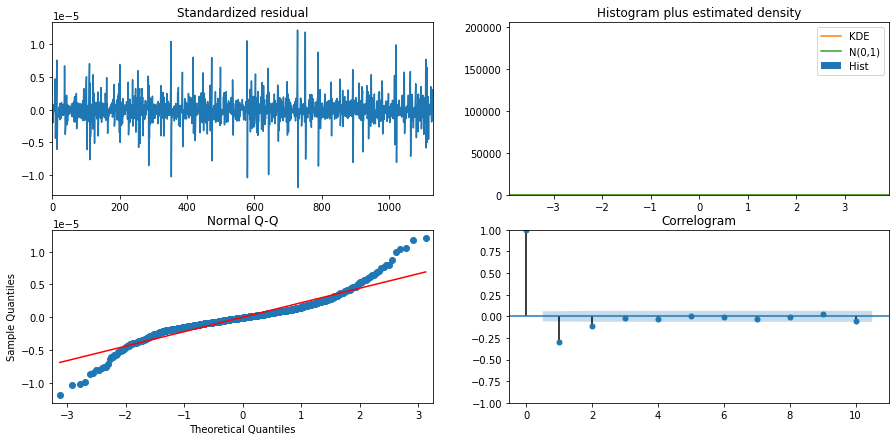

----------------------------------------------------------------------------------------------------


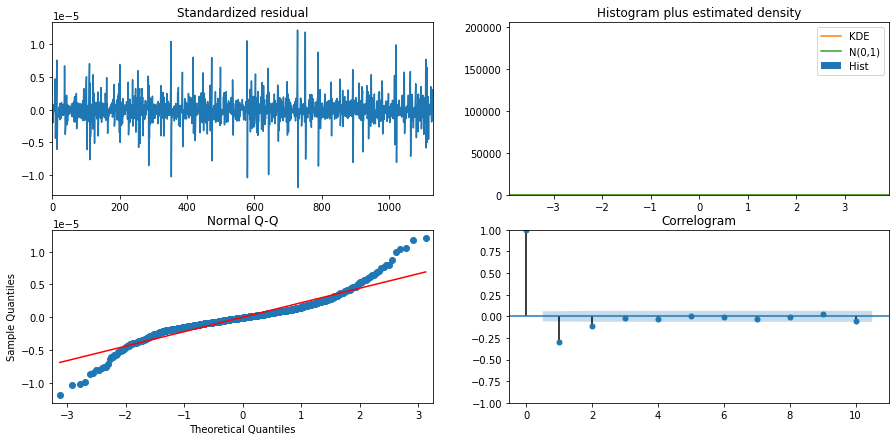

In [ ]:
for m in [1, 4, 7, 12, 52]:
    print('=' * 100)
    print(f'Fitting SARIMAX for seasonal value m = {str(m)}')
    stepwise_model = auto_arima(X_train, X_train_exog, start_p=1, start_q=1, max_p=7, max_q=7, seasonal=True, 
                                start_P=1, start_Q=1, max_P=7, max_Q=7, m=m, d=None, D=None, trace=True,
                                error_actions='ignore', suppress_warnings=True, stepwise=True)
    print(f'Model summary for m = {str(m)}')
    print('-' * 100)
    stepwise_model.summary()
    forecast, conf_int = stepwise_model.predict(n_periods=126, X=X_test_exog, return_conf_int=True)
    forecast = pd.DataFrame(forecast, columns=['Close_pred'])
    df_conf = pd.DataFrame(conf_int, columns=['Upper_bound', 'Lower_bound'])
    df_conf['new_index'] = np.arange(X_train.shape[0], df.shape[0])
    df_conf = df_conf.set_index('new_index')
    ts_eval_metrics(X_test, forecast)
    forecast['new_index'] = np.arange(X_train.shape[0], df.shape[0])
    forecast = forecast.set_index('new_index')
    get_ipython().run_line_magic('matplotlib', 'inline')
    plt.rcParams['figure.figsize'] = [15,7]
    plt.plot(X_train.values, label='Train')
    plt.plot(np.arange(X_train.shape[0], df.shape[0]), X_test.values, label='Test')
    plt.plot(forecast, label=f'Forecast for m = {m}')
    plt.plot(df_conf.Upper_bound, label='Confidence interval upper bound')
    plt.plot(df_conf.Lower_bound, label='Confidence interval lower bound')
    plt.legend(loc='best')
    plt.show()  
    print('-' * 100)
    print(f'Diagnostic plot for Seasonal value m = {m}')
    display(stepwise_model.plot_diagnostics())
    print('-' * 100)

In [ ]:
model = SARIMAX(endog=X_train, exog=X_train_exog, order=(0,1,0), seasonal_order=(0,0,0,4), trend='c')

In [ ]:
results = model.fit()

In [ ]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 1132
Model:               SARIMAX(0, 1, 0)   Log Likelihood               11971.205
Date:                Sat, 04 Dec 2021   AIC                         -23928.410
Time:                        07:40:24   BIC                         -23893.194
Sample:                             0   HQIC                        -23915.106
                               - 1132                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.694e-14   2.94e-15      5.753      0.000    1.12e-14    2.27e-14
Open        1.892e-14   3.38e-14      0.560      0.575   -4.72e-14    8.51e-14
High       -6.561e-15   5.61e-14     -0.117      0.907   -1.17e-13    1.03e-13
Low        -2.383e-14   3.33e-13     -0.072      0.943   -6.77e-13    6.29e-13
Adj Close      1.0000   3.44e-13    2.9e+12      0.000       1.000       1.000
Volume     -3.316e-17   7.18e-08  -4.62e-10      1.000   -1.41e-07    1.41e-07
sigma2          1e-10   6.26e-11      1.597      0.110   -2.27e-11    2.23e-10
===================================================================================
Ljung-Box (L1) (Q):                  98.57   Jarque-Bera (JB):              1614.93
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.92   Skew:                             0.21
Prob(H) (two-sided):                  0.42   Kurtosis:                         8.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.13e+28. Standard errors may be unstable.
"""

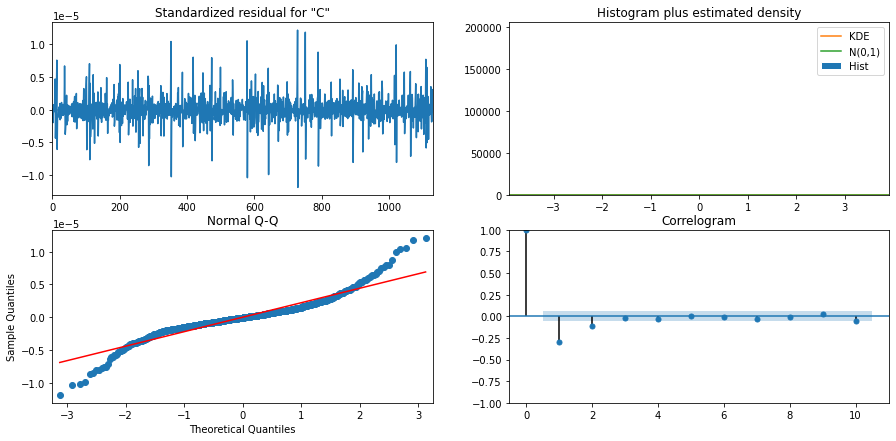

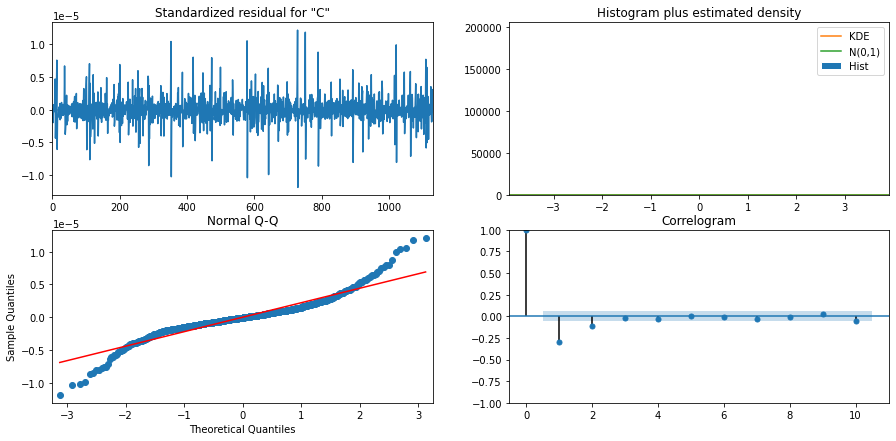

In [ ]:
results.plot_diagnostics()

In [ ]:
pred = results.predict(start=X_train.shape[0], end=df.shape[0]-1, exog=X_test_exog)

In [ ]:
ts_eval_metrics(X_test, pred)

Evaluation metrics results: 
MSE: 3.4964998348028313e-22
MAE: 1.4817184516383957e-11
RMSE: 1.8698930008967976e-11
MAPE: 7.309653772853266e-13
R^2: 1.0



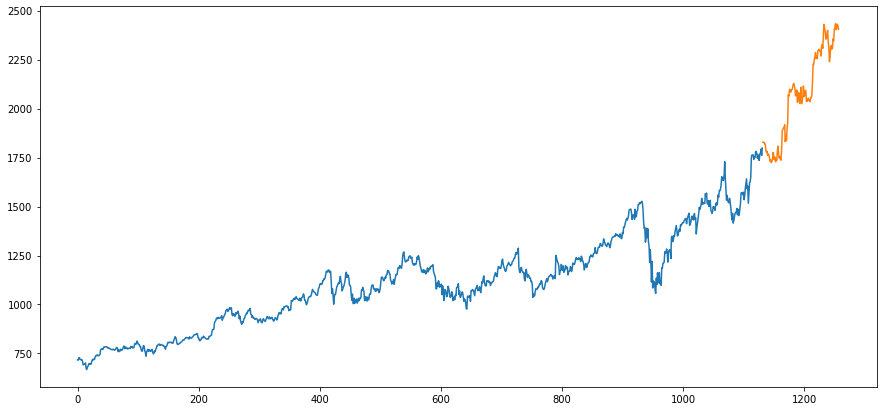

In [ ]:
plt.plot(np.arange(0, X_train.shape[0]), X_train)
plt.plot(np.arange(X_train.shape[0], df.shape[0]), pred)
plt.show()

In [ ]:
# NeuralProphet

In [ ]:
data_root_long = r'/content/drive/My Drive/data/exchange/google/GOOG_long.csv'

In [ ]:
data = pd.read_csv(data_root_long)

In [ ]:
data.Date = pd.to_datetime(data.Date)

In [ ]:
data = data.rename(columns={"Date":"ds","Close":"y"})

In [ ]:
#data_train, data_test = train_test_split(data, test_size=0.1, shuffle=False, random_state=1)
data_train, data_test = data.iloc[:-200, :], data.iloc[-200:, :]

In [ ]:
import torch
torch.random.random_state = 1

In [ ]:
from neuralprophet import NeuralProphet

m = NeuralProphet(
    n_forecasts=60,
    n_lags=60,
    n_changepoints=50,
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    batch_size=64,
    epochs=100,
    learning_rate=.1,
)

In [ ]:
m = NeuralProphet()

In [ ]:
for col in data.columns:
    if col not in ['ds', 'y']:
        m.add_future_regressor(col, normalize='auto')

In [ ]:
help(NeuralProphet)

In [ ]:
# metrics = m.fit(data[['ds', 'y']], freq="D")  # fit the model using all data
# with cross-validation
metrics = m.fit(data_train, freq='D', epochs=200, validation_df=data_test)

INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32


  0%|          | 0/259 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.90E-01, min: 1.53E+00


  0%|          | 0/259 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.06E-01, min: 1.80E+00


  0%|          | 0/259 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.06E-01, min: 1.53E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 2.01E-01
Epoch[200/200]: 100%|██████████| 200/200 [00:22<00:00,  9.00it/s, SmoothL1Loss=2.29e-6, MAE=1.7, RMSE=2.41, RegLoss=0, MAE_val=3.91, RMSE_val=4.98, SmoothL1Loss_val=9.31e-6]


In [ ]:
# without exogenious variables
future = m.make_future_dataframe(data_train[['ds', 'y']], periods=len(data_test), n_historic_predictions=len(data_train))

In [ ]:
#future = m.make_future_dataframe(data_train[['ds', 'y']], periods=126) #, n_historic_predictions=len(data_train))
future = m.make_future_dataframe(data_train, periods=len(data_test), n_historic_predictions=len(data_train), 
                                 regressors_df=data_test.drop(['ds', 'y'], axis=1))

In [ ]:
prediction = m.predict(future)

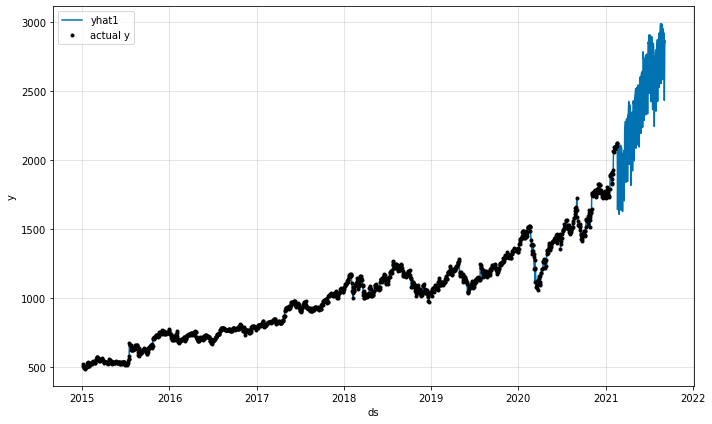

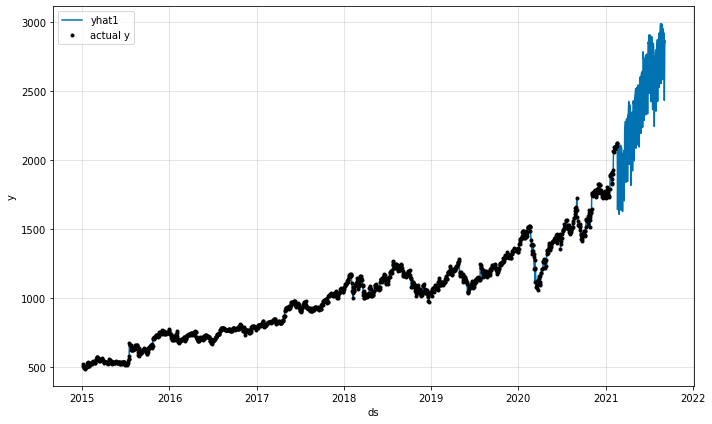

In [ ]:
m.plot(prediction)

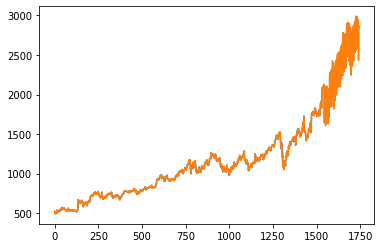

In [ ]:
plt.plot(np.arange(0, data_train.shape[0]), data_train.y)
plt.plot(np.arange(len(prediction)), prediction.yhat1)
plt.show()

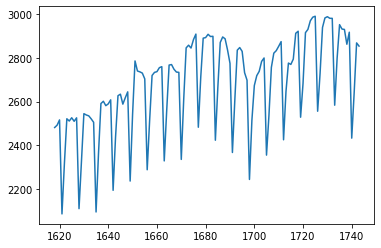

In [ ]:
prediction.yhat1[-126:].plot()

In [ ]:
ts_eval_metrics(data_test.y, prediction.yhat1[-200:])

Evaluation metrics results: 
MSE: 32439.403847494847
MAE: 94.23241765265624
RMSE: 180.1094218731903
MAPE: 3.740345215152765
R^2: 0.6338225917484905



In [ ]:
m.model

TimeNet(
  (season_params): ParameterDict(
      (weekly): Parameter containing: [torch.FloatTensor of size 6]
      (yearly): Parameter containing: [torch.FloatTensor of size 12]
  )
  (regressor_params): ParameterDict(
      (additive): Parameter containing: [torch.FloatTensor of size 5]
      (multiplicative): Parameter containing: [torch.FloatTensor of size 0]
  )
)